# Imports:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import chi2

from tqdm import tqdm, trange
import random

In [2]:
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
from scipy.special import expit, logit

# Hyperparameters:

In [3]:
pop_size = 100 * 1_000
sample_size = 30
agg_iters = 100_00

beta = 1

## for biased sampling mechanism:
sample_probability_centering = 0.8
sample_probability_bias_factor = 0.1

In [4]:
## for rng generator:
pop_number = 1

# Run:

In [5]:
rand_generator = np.random.default_rng(seed=333 * pop_number)

In [6]:
assert pop_size % 100 == 0
base_x = [i for i in range(-50, 0)] + [i for i in range(1, 51)]
x = pd.Series(base_x * (pop_size // 100))

y_stdev_power_of_x = 4

In [7]:
fitted_betas = []
fitted_FI = []
fitted_correlations = []
realized_sample_sizes = []

Create the simulated data (x, y):

In [8]:
y = x * beta + rand_generator.normal(size=pop_size) * (x ** (y_stdev_power_of_x // 2))

data = pd.concat([y, x], axis=1)

data.columns = ['y', 'x']

fitted_beta = sm.OLS(data['y'], data['x']).fit().params.iloc[0]

data['g_star'] = data['x'] * (data['y'] - data['x'] * fitted_beta)

In [9]:
marginal_probabilities = expit(logit(sample_probability_centering) + \
                               sample_probability_bias_factor * (data['x'].abs() - 25.5))

# run:

In [10]:
for _ in tqdm(range(agg_iters)):
    srs_sample_indices = pd.Series(random.sample(range(pop_size), sample_size))
    srs_sample_indices = srs_sample_indices.sort_values().reset_index(drop=True)

    # reset the sample
    data['r0'] = 0
    data['r'] = 0
    data['r1'] = 0
    data['r2'] = 0
    
    data.loc[srs_sample_indices, 'r0'] = 1
    full_sampled_data = data[data['r0'] == 1]

    biased_sample_indices = marginal_probabilities.index[rand_generator.binomial(n=1, p = marginal_probabilities) == 1]

    data.loc[biased_sample_indices, 'r'] = 1

    biased_sample_indices_size = len(biased_sample_indices)
    realized_sample_sizes.append(biased_sample_indices_size)


    srs_sample = data[data['r0'] == 1].copy()
    biased_sample = data[data['r'] == 1].copy()

    srs_fitted_beta = sm.OLS(srs_sample['y'], srs_sample['x']).fit().params.iloc[0]
    biased_fitted_beta = sm.OLS(biased_sample['y'], biased_sample['x']).fit().params.iloc[0]

    fitted_betas.append(pd.Series([fitted_beta, srs_fitted_beta, biased_fitted_beta]))

    fitted_FI.append(pd.Series([np.mean(srs_sample['x'] ** 2), np.mean(biased_sample['x'] ** 2)]))

    fitted_correlations.append(data[['g_star', 'r0', 'r']].corr().iloc[0, 1:])

100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:12<00:00, 39.60it/s]


Clean up the data:

In [13]:
fitted_betas = pd.concat(fitted_betas, axis=1).T
fitted_FI = pd.concat(fitted_FI, axis=1).T
fitted_correlations = pd.concat(fitted_correlations, axis=1).T.reset_index(drop=True)

In [14]:
fitted_FI.columns = ['srs', 'biased']
fitted_betas.columns = ['population', 'srs', 'biased']
fitted_correlations.columns = ['srs', 'biased']

In [15]:
realized_sample_sizes = pd.Series(realized_sample_sizes)

In [16]:
fitted_FI.head()

,srs,biased
0,790.200000,1069.706870
1,808.733333,1069.301200
2,908.000000,1068.272182
3,976.766667,1068.335264
4,813.433333,1067.513695


In [17]:
fitted_FI.tail()

,srs,biased
9995,1009.666667,1066.036181
9996,806.733333,1066.468934
9997,931.166667,1070.450726
9998,557.266667,1070.571387
9999,560.466667,1069.656232


# Plot:

In [18]:
fitted_FI_and_corr = fitted_FI.join(fitted_correlations, lsuffix = '_fi', rsuffix = '_corr')

fitted_FI_and_corr.head()

,srs_fi,biased_fi,srs_corr,biased_corr
0,790.200000,1069.706870,-0.000072,-0.001141
1,808.733333,1069.301200,0.002934,0.000472
2,908.000000,1068.272182,-0.001124,0.002401
3,976.766667,1068.335264,-0.001087,-0.000492
4,813.433333,1067.513695,0.003140,0.003240


In [19]:
fitted_FI_and_corr.to_pickle('variance_function_bias.pkl')

In [21]:
fitted_FI_and_corr.head()

,srs_fi,biased_fi,srs_corr,biased_corr
0,790.200000,1069.706870,-0.000072,-0.001141
1,808.733333,1069.301200,0.002934,0.000472
2,908.000000,1068.272182,-0.001124,0.002401
3,976.766667,1068.335264,-0.001087,-0.000492
4,813.433333,1067.513695,0.003140,0.003240


Text(0.5, 0.01, 'Jn (across sampling mechanisms)')

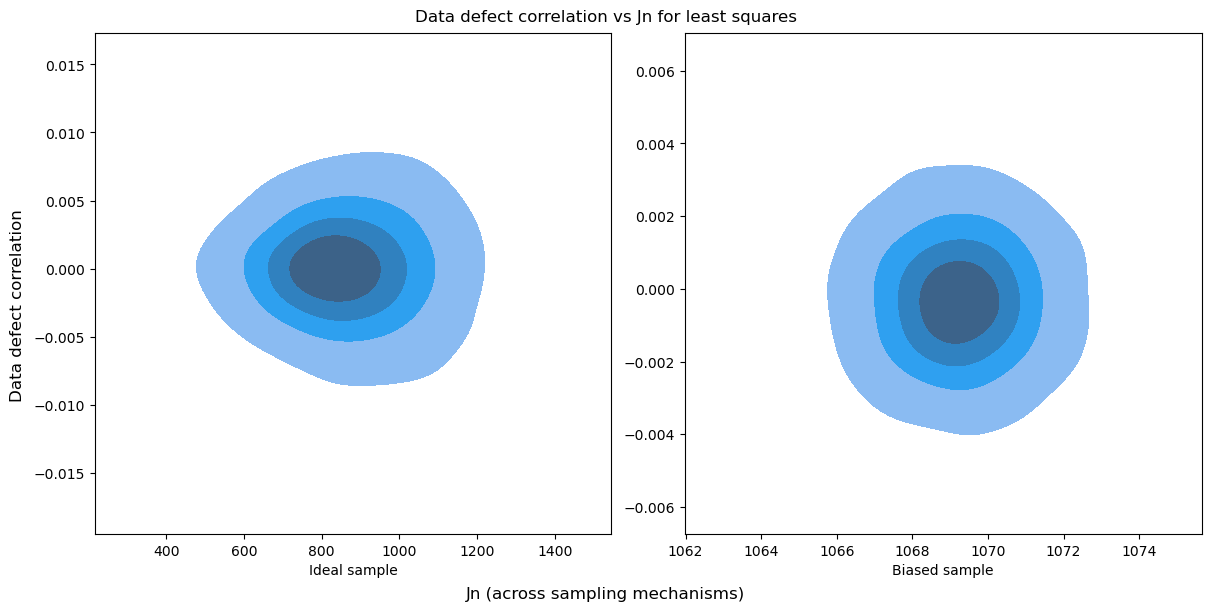

In [22]:
fig, axes = plt.subplots(1, 2, 
                         constrained_layout=True, 
                         figsize=(12, 6))

ax = axes[0]
sns.kdeplot(data = fitted_FI_and_corr, 
            x=f'srs_fi',
            y = f'srs_corr', 
            fill=True, 
            bw_adjust=1.8, 
            levels=5,
            ax=ax
           )
ax.set_xlabel('Ideal sample')
ax.set_ylabel('')

ax = axes[1]
sns.kdeplot(data = fitted_FI_and_corr, 
            x=f'biased_fi',
            y = f'biased_corr', 
            fill=True, 
            bw_adjust=1.8, 
            levels=5,
            ax=ax
           )
ax.set_xlabel('Biased sample')
ax.set_ylabel('')

fig.suptitle('Data defect correlation vs Jn for least squares')
fig.supylabel('Data defect correlation')
fig.supxlabel('Jn (across sampling mechanisms)')
# plt.savefig('ddc_vs_sample_elasticity_ols.png', bbox_inches = 'tight')

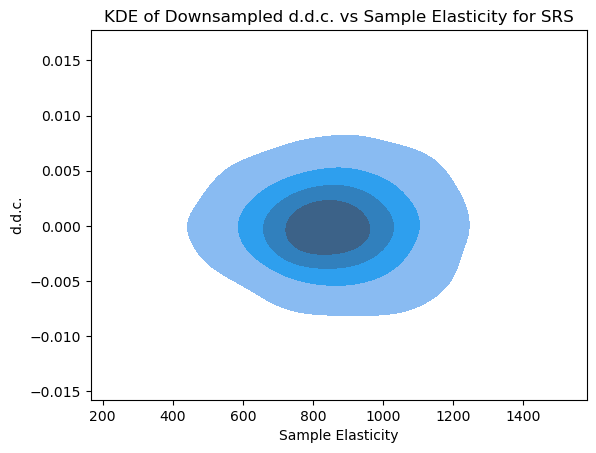

In [110]:
sns.kdeplot(data = fitted_FI_and_corr[::10], x=f'{beta1_name}_fi', \
            y = f'{beta1_name}_corr', fill=True, bw_adjust=1.8, levels=5)
plt.title('KDE of Downsampled d.d.c. vs Sample Elasticity for SRS')
plt.xlabel('Sample Elasticity')
plt.ylabel('d.d.c.')
plt.savefig('kde_downsampled_ddc_vs_sample_elasticity_srs_ols_pop_fixed.png', bbox_inches = 'tight')

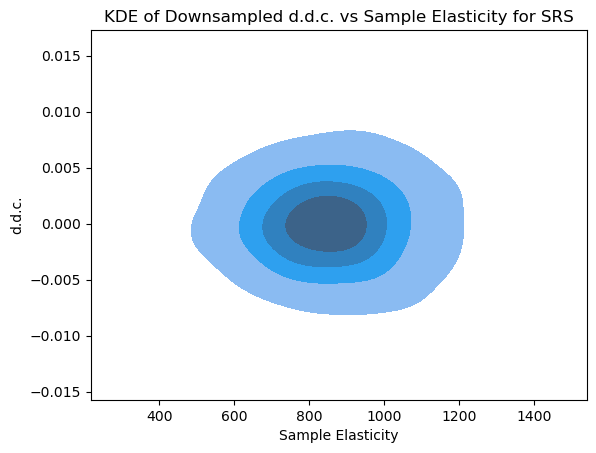

In [112]:
sns.kdeplot(data = fitted_FI_and_corr[::10], x=f'srs_fi', \
            y = f'srs_corr', fill=True, bw_adjust=1.8, levels=5)
plt.title('KDE of Downsampled d.d.c. vs Sample Elasticity for SRS')
plt.xlabel('Sample Elasticity')
plt.ylabel('d.d.c.')
plt.savefig('kde_downsampled_ddc_vs_sample_elasticity_srs_ols_pop_fixed_upper_level.png', bbox_inches = 'tight')

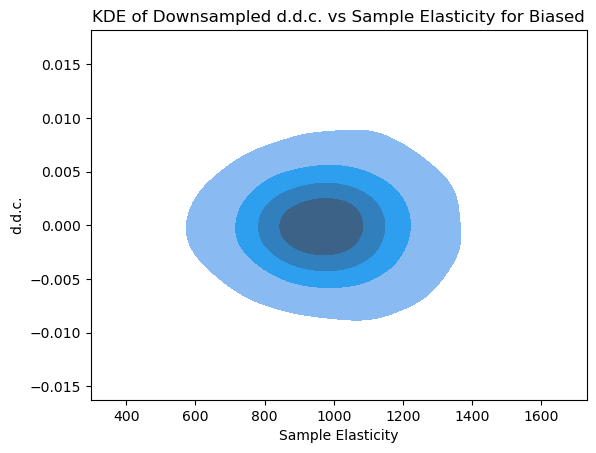

In [111]:
sns.kdeplot(data = fitted_FI_and_corr[::10], x=f'{beta2_name}_fi', \
            y = f'{beta2_name}_corr', fill=True, bw_adjust=1.8, levels=5)
plt.title('KDE of Downsampled d.d.c. vs Sample Elasticity for Biased')
plt.xlabel('Sample Elasticity')
plt.ylabel('d.d.c.')
plt.savefig('kde_downsampled_ddc_vs_sample_elasticity_biased_ols_pop_fixed.png', bbox_inches = 'tight')